# FORECASTING MELI COSTS USING SARIMAX

To understand how **statsmodels** package works, please read

https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

## PACKAGES

In [2]:
import os # for handling files
import matplotlib
import matplotlib.pyplot as plt
import warnings # for handling warning messages
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import itertools # collection of tools for handling iterators
import numpy as np
import pandas as pd
import statsmodels.api as sm # 
'''
provides classes and functions for the estimation of many different
statistical models, as well as for conducting statistical tests, 
and statistical data exploration.
'''

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## DATA PROCESSING
### LOADING

In [3]:
os.chdir('/Users/homocuadratus/Google Drive/DATA SCIENCE/CHALLENGES/MELI CHALLENGE/TIME SERIES/')
# adapt filepath to point to the folder .xlsx file is
costs_raw = os.path.abspath("meli_ec2_blended_cost_may_2019.xlsx")
df_costs = pd.read_excel(costs_raw)

### INDEXING 

We use time data as an index for our dataframe

In [4]:
df_costs = df_costs.set_index('ds')

### RESAMPLING 
We resample data using a daily frequency

In [5]:
df_costs_monthly = df_costs['y'].resample('D').mean()

In [6]:
df_costs_monthly.head(3)

ds
2019-05-01    774.111453
2019-05-02    804.738605
2019-05-03    816.846227
Freq: D, Name: y, dtype: float64

### VISUALIZING

#### EXPLORATORY VISUALIZATION

We make an exploratory visulization of data using pyplot.

First, we show a plot of the raw data

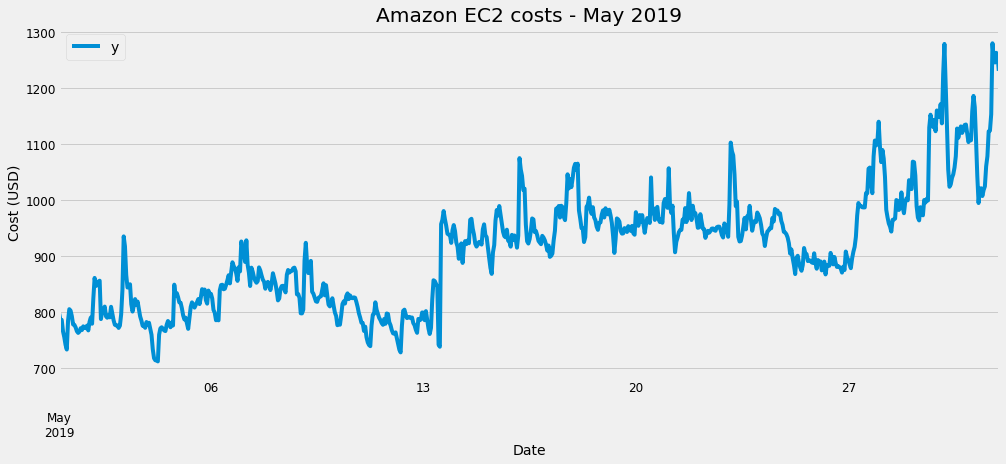

In [7]:
df_costs.plot(figsize=(15, 6))
plt.title('Amazon EC2 costs - May 2019')
plt.xlabel('Date')
plt.ylabel('Cost (USD)')
#plt.legend()
plt.show()

and then, we see how the above data looks when downsampled using an average daily value

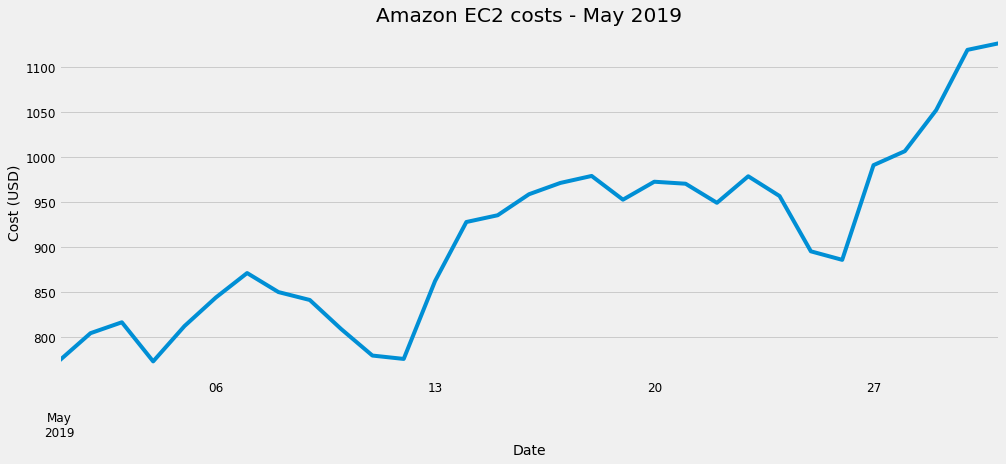

In [8]:
df_costs_monthly.plot(figsize=(15, 6))
plt.title('Amazon EC2 costs - May 2019')
plt.xlabel('Date')
plt.ylabel('Cost (USD)')
#plt.legend()
plt.show()

#### STATSMODEL DECOMPOSITION

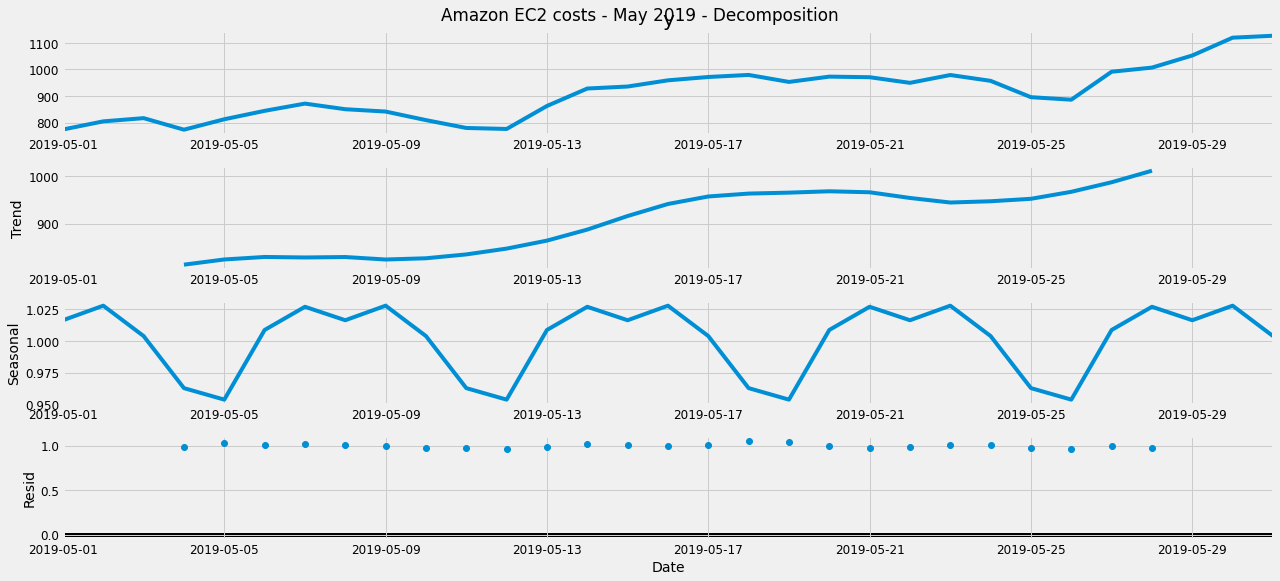

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(df_costs_monthly, model='multiplicative')
fig = decomposition.plot()
plt.xlabel('Date')
fig.suptitle('Amazon EC2 costs - May 2019 - Decomposition')
plt.show()

## FORECASTING PROCESS
### INTRODUCTION

Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA 
that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I), and moving 
average (MA) for the seasonal component of the series, as well as an additional parameter for the 
period of the seasonality.

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series. Concretely, for the ARIMA part we have

* p: Trend autoregression order
* d: Trend difference order
* q: Trend moving average order

and for the seasonal elements,

* P: Seasonal autoregressive order
* D: Seasonal difference order
* Q: Seasonal moving average order
* m: The number of time steps for a single seasonal period

Having this into account, we can denote a certain SARIMA model as

**SARIMA(p,d,q)(P,D,Q,m)**

### FINDING THE BEST MODEL

#### STATIONARITY TEST



We will perform a grid search for finding the set of parameters that minimizes AIC. To do that, we prepare the grid

In [42]:
#ADF-test(Original-time-series)
adf_test_results_original = sm.tsa.adfuller(df_costs,regression='ct')
f'p-value: {adf_test_results_original[1]}'

'p-value: 0.0001902129688982882'

In [ ]:
#ADF-test(Original-differenced-time-series)
adf_test_results_original_differenced = sm.tsa.adfuller(df_costs.diff().dropna(),regression='c')
f'p-value:{adf_test_results_original_differenced[1]}'

In [41]:
#ADF-test(Downsampled-time-series)
adf_test_results_downsampled = sm.tsa.adfuller(df_costs_monthly,regression='ct')
f'p-value: {adf_test_results_downsampled[1]}'

'p-value: 0.12619931283720426'

In [31]:
# we make three ranges (0,1) and store them in p, d, q respectively
p = d = q = range(0, 2) 
# we use itertools.product to make a cartesian product of p, d, q and then we store its results in a list called pdq
pdq = list(itertools.product(p, d, q))
# we do the same for the seasonal parameters, having set m = 7 (weekly seasonal period)
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in pdq]

In [32]:
print('Examples of parameter combinations for Seasonal ARIMA...')
f"SARIMAX: {pdq[0]} x {seasonal_pdq[1]} " \
f"SARIMAX: {pdq[1]} x {seasonal_pdq[2]} " \
f"SARIMAX: {pdq[2]} x {seasonal_pdq[0]} " \
f"SARIMAX: {pdq[1]} x {seasonal_pdq[1]} "

Examples of parameter combinations for Seasonal ARIMA...


'SARIMAX: (0, 0, 0) x (0, 0, 1, 7) SARIMAX: (0, 0, 1) x (0, 1, 0, 7) SARIMAX: (0, 1, 0) x (0, 0, 0, 7) SARIMAX: (0, 0, 1) x (0, 0, 1, 7) '

and then we fit the SARIMAX model for each combination of parameters in the grid, compare the AICs and choose the set that minimizes it:

In [38]:
arima_parameters = []
seasonal_parameters = []
AIC = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # SARIMAX MODEL INITIALIZATION
            sarimax = sm.tsa.statespace.SARIMAX(df_costs_monthly,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            # SARIMAX MODEL FITTING
            fitted_sarimax = sarimax.fit()
            
            arima_parameters.append(param)
            
            seasonal_parameters.append(param_seasonal)
            
            AIC.append(fitted_sarimax.aic)
            
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, np.round(fitted_sarimax.aic,2)))

        except:
            continue

# we obtain index for minimum AIC

min_AIC_index = AIC.index(min(AIC))

f'The optimum set of parameters for SARIMAX model is [p,d,q]: {arima_parameters[min_AIC_index]}, [P,D,Q,m]: {seasonal_parameters[min_AIC_index]}. For that choice we get an AIC index of {np.round(AIC[min_AIC_index],2)}'

ARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC:496.65
ARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC:364.87
ARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC:277.23
ARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC:763.55
ARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC:280.94
ARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC:258.03
ARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC:211.95
ARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC:779.44
ARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC:446.34
/Users/homocuadratus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
ARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC:326.66
ARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC:247.23
ARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC:637.07
/Users/homocuadratus/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/homocuadratus/opt/anaconda3/lib/python3.7/site-

'The optimum set of parameters for SARIMAX model is [p,d,q]: (0, 1, 1), [P,D,Q,m]: (1, 1, 1, 7). For that choice we get an AIC index of 142.4'

### MODEL FITTING

Having found the set of parameters that minimizes AIC, we 

In [19]:
mod = sm.tsa.statespace.SARIMAX(df_costs_monthly,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1329      0.355     -3.194      0.001      -1.828      -0.438
ar.S.L7       -1.1645      0.130     -8.943      0.000      -1.420      -0.909
ma.S.L7        0.9758     25.297      0.039      0.969     -48.606      50.557
sigma2       418.5425   1.05e+04      0.040      0.968   -2.02e+04    2.11e+04


#### RESIDUAL ANALYSIS

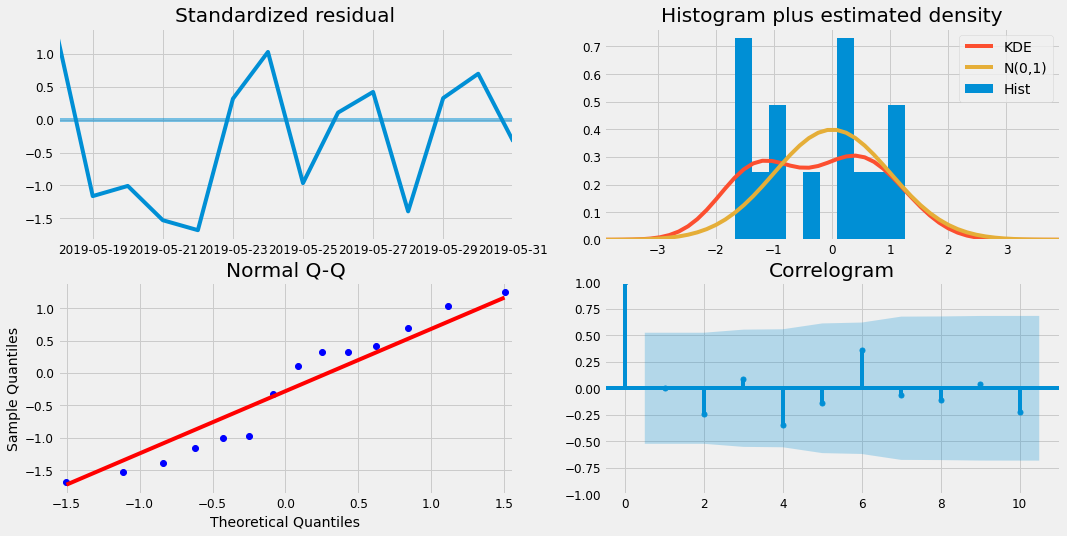

In [20]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#### LATE TAIL COMPARISON

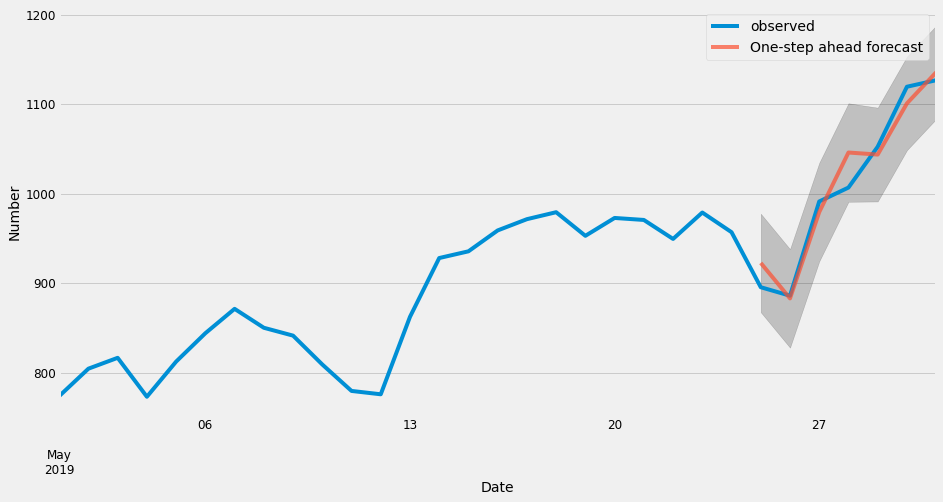

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2019-05-25'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_costs_monthly['2019-05-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Number')
plt.legend()
plt.show()

#### FORECAST

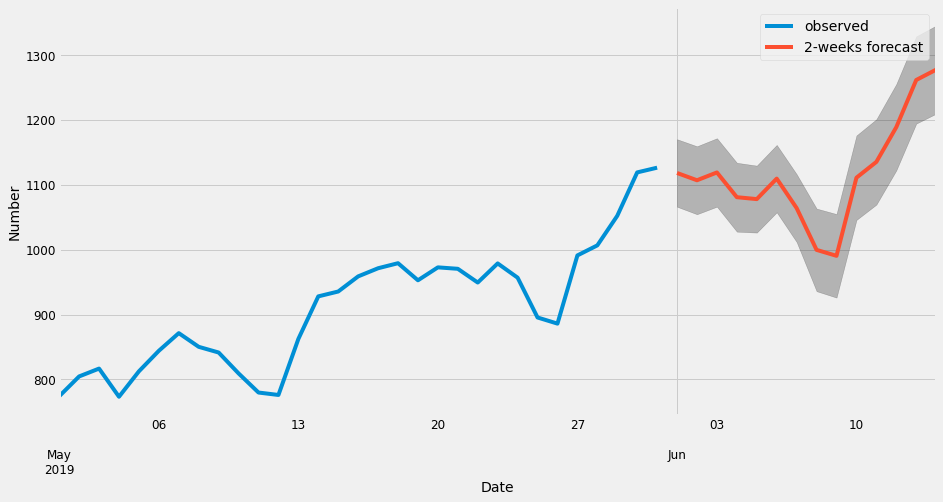

In [22]:
pred_uc = results.get_forecast(steps=14)
pred_ci = pred_uc.conf_int()
ax = df_costs_monthly.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='2-weeks forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Number')
plt.legend()
plt.show()